<a href="https://colab.research.google.com/github/AnushkaaBhargava/plant-disease-detection/blob/main/training/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [48]:
IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS=30
CHANNELS=3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

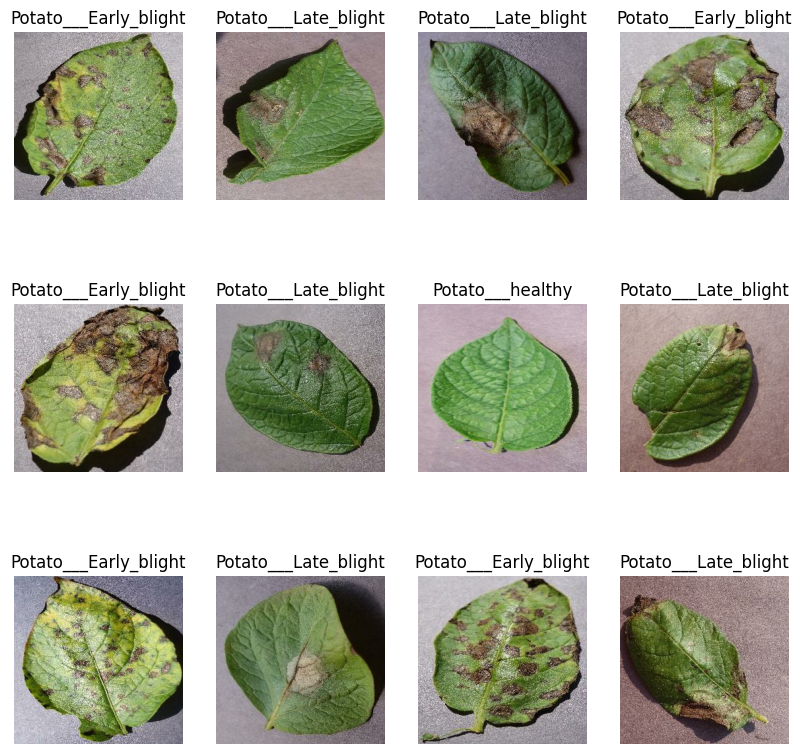

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")



In [7]:
import os

base = "/content/drive/MyDrive/PlantVillage"
for folder in os.listdir(base):
    path = os.path.join(base, folder)
    print(folder, len(os.listdir(path)))


Potato___healthy 152
Potato___Early_blight 1000
Potato___Late_blight 1000


In [8]:
import os
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

base_path = "/content/drive/MyDrive/PlantVillage"

# Get subfolder names (class names)
class_names = sorted(os.listdir(base_path))

# Count files in each folder
counts = [len(os.listdir(os.path.join(base_path, c))) for c in class_names]

print("Class names:", class_names)
print("Counts:", counts)

# Generate labels manually (0,1,2,...)
y_labels = []
for idx, count in enumerate(counts):
    y_labels.extend([idx] * count)
y_labels = np.array(y_labels)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Counts: [1000, 1000, 152]
Class weights: {0: np.float64(0.7173333333333334), 1: np.float64(0.7173333333333334), 2: np.float64(4.719298245614035)}


In [9]:
len(dataset)

68

In [10]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds=dataset.take(54)
len(train_ds)

54

In [12]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size


6.800000000000001

In [14]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_paritions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds



In [17]:
train_ds,val_ds,test_ds=get_dataset_paritions(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [44]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2)
])


In [45]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1./255)
])


In [46]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf

IMAGE_SIZE = 224
BATCH_SIZE = 32
n_classes = 3

# ✅ Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# ✅ Pretrained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False  # freeze base layers

# ✅ Final model
model = Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [47]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Change the file extension here
checkpoint_filepath = '/content/drive/MyDrive/best_model_checkpoint.weights.h5' # <-- Changed from .keras

# Create the ModelCheckpoint callback (rest of the code is the same)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Now you can use this callback in model.fit()
# history = model.fit(..., callbacks=[model_checkpoint_callback])


history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback],
      class_weight=class_weights
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7929 - loss: 0.4558
Epoch 1: val_loss improved from inf to 0.12006, saving model to /content/drive/MyDrive/best_model_checkpoint.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.7943 - loss: 0.4527 - val_accuracy: 0.9271 - val_loss: 0.1201
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9479 - loss: 0.1245
Epoch 2: val_loss did not improve from 0.12006
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9480 - loss: 0.1245 - val_accuracy: 0.9219 - val_loss: 0.1957
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9575 - loss: 0.1165
Epoch 3: val_loss did not improve from 0.12006
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9572 - loss: 0.1175 - val_accuracy: 0.6823 - val_loss: 1.2676
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9047 - loss: 0.2479
Epoch 4: val_loss improved from 0.12006 to 0.05461, saving model to /content/drive/MyDrive/best_

In [64]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

save_path = "/content/drive/MyDrive/plant-disease-detection/models"
os.makedirs(save_path, exist_ok=True)

# ✅ Correct filename extension
model.save_weights(f"{save_path}/disease_model.weights.h5")
print("✅ Saved weights to:", f"{save_path}/disease_model.weights.h5")


Mounted at /content/drive
✅ Saved weights to: /content/drive/MyDrive/plant-disease-detection/models/disease_model.weights.h5


In [50]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9731 - loss: 0.0889


In [51]:
scores

[0.09340707212686539, 0.9609375]

In [52]:
history

In [53]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [54]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [55]:
acc=history.history["accuracy"]
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

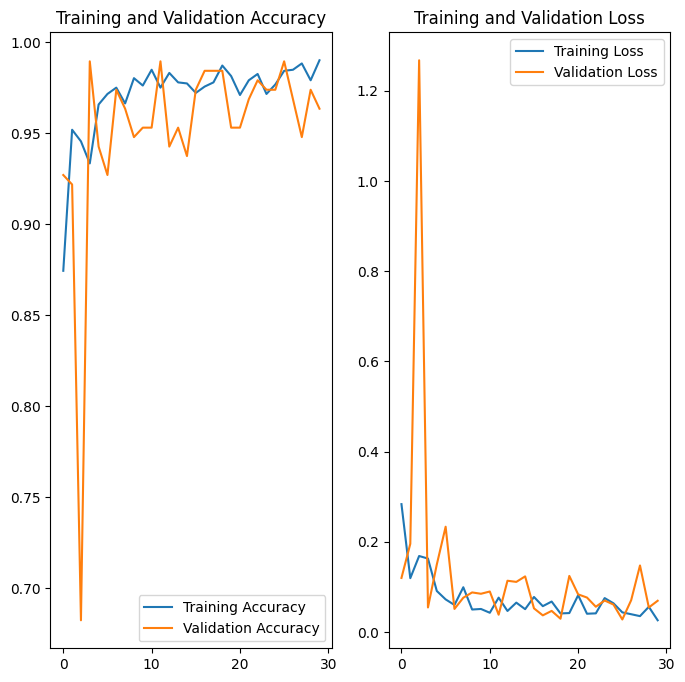

In [56]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()




first image to predict
first image's actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Potato___Early_blight


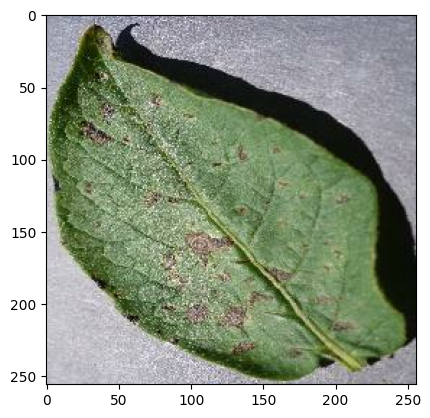

In [57]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()
  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:",class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [58]:
import tensorflow as tf
import numpy as np

def predict(model, img):
  """
  Makes a prediction on a single image using the trained model.

  Args:
    model: The trained tf.keras model.
    img: The input image (e.g., loaded using tf.keras.utils.load_img or as a NumPy array).
    class_names: A list of strings containing the names of the classes.

  Returns:
    A tuple containing the predicted class name (string) and the confidence score (float).
  """
  # Convert the image to a NumPy array
  img_array = tf.keras.preprocessing.image.img_to_array(img)

  # Add a batch dimension (model expects batches)
  img_array = tf.expand_dims(img_array, 0) # Create a batch of size 1

  # Get model predictions (an array of probabilities for each class)
  predictions = model.predict(img_array)

  # Find the class index with the highest probability
  predicted_index = np.argmax(predictions[0])

  # Get the corresponding class name
  predicted_class = class_names[predicted_index]

  # Get the confidence score (highest probability)
  confidence = round(100 * (np.max(predictions[0])), 2)

  return predicted_class, confidence

# --- Example Usage (replace with your actual variables) ---
# Assuming you have:
# 1. Loaded your trained Keras model into the variable 'model'
# 2. A list of your class labels in 'class_names' (e.g., ['ClassA', 'ClassB', 'ClassC'])
# 3. Loaded an image you want to predict into 'my_image'
#    (e.g., my_image = tf.keras.utils.load_img('path/to/your/image.jpg', target_size=(IMAGE_SIZE, IMAGE_SIZE)))

# predicted_label, confidence_score = predict(model, my_image)
# print(f"Predicted Class: {predicted_label}")
# print(f"Confidence: {confidence_score}%")
# --- End Example ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


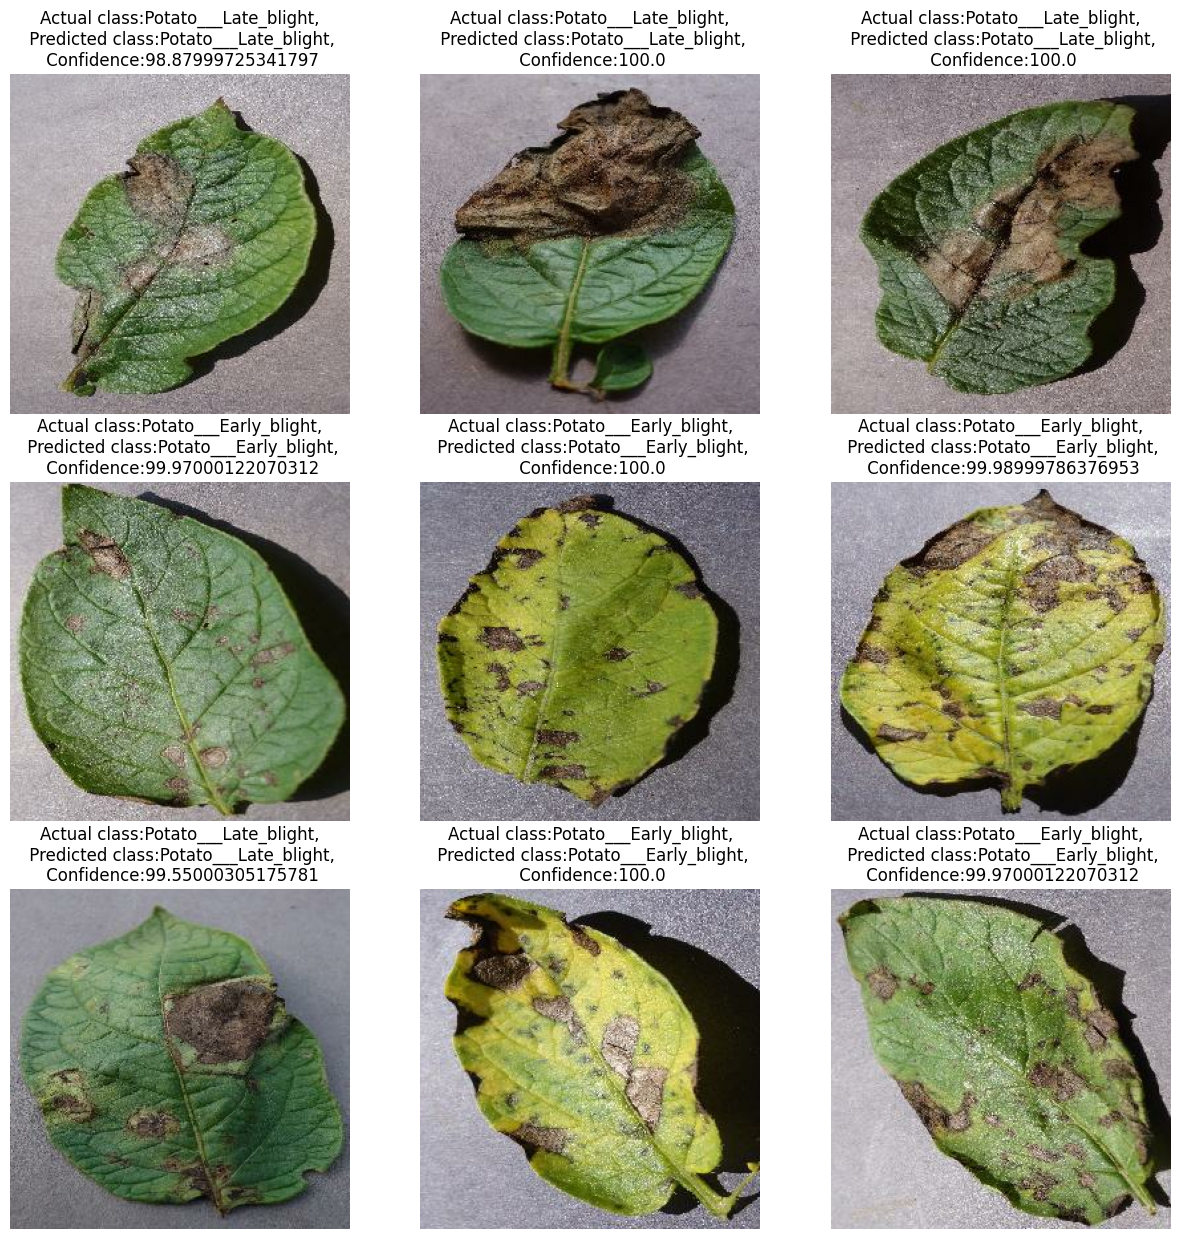

In [59]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual class:{actual_class},\n Predicted class:{predicted_class},\n Confidence:{confidence}")
    plt.axis("off")

In [60]:
model.save("model.keras")

from google.colab import files
files.download("model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
from google.colab import drive
drive.mount('/content/drive')

import os

save_path = "/content/drive/MyDrive/plant-disease-detection/models"
os.makedirs(save_path, exist_ok=True)

model.save(f"{save_path}/1.keras")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
